# Classifier comparison script from documentation
Modified the code from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html, scikit learn documentation, in a similar way to https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb.

In [20]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 1

In [139]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]
RANDOM_STATE = 1

classifiers = [
    KNeighborsClassifier(n_neighbors = 32, p=2, weights='uniform'),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(random_state=RANDOM_STATE),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [95]:
def import_and_split_data_1():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [ ]:
def import_and_split_data_10():
    # import data such that each group of 10 for which a label is provided is grouped into a single row
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = np.zeros((len(train_labels['label']), 30))
    for i in range(len(train_labels['label'])):
        first_index = 10*i
        last_index = first_index + 10
        train_X[i][0:10] = train_time_series['x'].iloc[first_index:last_index].to_numpy()
        train_X[i][10:20] = train_time_series['y'].iloc[first_index:last_index].to_numpy()
        train_X[i][20:30] = train_time_series['z'].iloc[first_index:last_index].to_numpy()

    test_X = np.zeros((len(test_labels['label']), 30))
    for i in range(len(test_labels['label'])):
        first_index = 10*i
        last_index = first_index + 10
        test_X[i][0:10] = test_time_series['x'].iloc[first_index:last_index].to_numpy()
        test_X[i][10:20] = test_time_series['y'].iloc[first_index:last_index].to_numpy()
        test_X[i][20:30] = test_time_series['z'].iloc[first_index:last_index].to_numpy()

    train_Y = train_labels['label'].to_numpy()
    test_Y = test_labels['label'].to_numpy()

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [106]:
def import_and_split_data_3_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from one time step before and after
    train_X = np.concatenate((train_X[1:-1,:],train_X[0:-2],train_X[2:]),axis=1) # horizontally
    train_Y = train_Y[1:-1]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [119]:
def import_and_split_data_5_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[2:-2,:],train_X[1:-3,:],train_X[0:-4,:],train_X[3:-1,:],train_X[4:,:]),axis=1) # horizontally
    train_Y = train_Y[2:-2]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [129]:
def import_and_split_data_9_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[4:-4,:],
                              train_X[0:-8,:],
                              train_X[1:-7,:],
                              train_X[2:-6,:],
                              train_X[3:-5,:],
                              train_X[5:-3,:],
                              train_X[6:-2,:],
                              train_X[7:-1,:],
                              train_X[8:,:])
                             ,axis=1) # horizontally
    train_Y = train_Y[4:-4]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [181]:
def import_and_split_data_9_window_w_extra_stats():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[4:-4,:],
                              train_X[0:-8,:],
                              train_X[1:-7,:],
                              train_X[2:-6,:],
                              train_X[3:-5,:],
                              train_X[5:-3,:],
                              train_X[6:-2,:],
                              train_X[7:-1,:],
                              train_X[8:,:])
                             ,axis=1) # horizontally
    
    # add mean x and z, as well as x std - across the 9 observations in the window - as features
    x_values = train_X[:,3*np.linspace(0,8,9).astype(int)]
    z_values = train_X[:,3*np.linspace(0,8,9).astype(int)+2]
    x_mean = np.mean(x_values, axis=1)
    z_mean = np.mean(z_values, axis=1)
    x_std = np.std(x_values, axis=1)
    
    extra_stats = np.vstack(( x_mean, z_mean, x_std))
    train_X = np.concatenate((train_X, extra_stats.T), axis=1)
    
    train_Y = train_Y[4:-4]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [248]:
def import_and_split_data_19_window_w_extra_stats():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])

        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[9:-9,:],
                              train_X[0:-18,:],
                              train_X[1:-17,:],
                              train_X[2:-16,:],
                              train_X[3:-15,:],
                              train_X[4:-14,:],
                              train_X[5:-13,:],
                              train_X[6:-12,:],
                              train_X[7:-11,:],
                              train_X[8:-10,:],
                              train_X[10:-8,:],
                              train_X[11:-7,:],
                              train_X[12:-6,:],
                              train_X[13:-5,:],
                              train_X[14:-4,:],
                              train_X[15:-3,:],
                              train_X[16:-2,:],
                              train_X[17:-1,:],
                              train_X[18:,:])
                             ,axis=1) # horizontally
    
    # add mean x and z, as well as x std - across the 19 observations in the window - as features
    x_values = train_X[:,3*np.linspace(0,18,19).astype(int)]
    y_values = train_X[:,3*np.linspace(0,18,19).astype(int)+1]
    z_values = train_X[:,3*np.linspace(0,18,19).astype(int)+2]
    x_mean = np.mean(x_values, axis=1)
    y_mean = np.mean(y_values, axis=1)
    z_mean = np.mean(z_values, axis=1)
    x_std = np.std(x_values, axis=1)
    y_std = np.std(y_values, axis=1)
    z_std = np.std(z_values, axis=1)
    
    extra_stats = np.vstack(( x_mean, y_mean, z_mean, x_std, y_std,z_std))
    train_X = np.concatenate((train_X, extra_stats.T), axis=1)
    
    train_Y = train_Y[9:-9]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [229]:
def import_and_split_data_19_window_w_extra_stats_only_labelled():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()
    train_Y = train_labels['label'].to_numpy()
            
    # copy x y z from two time steps before and after
    train_X_top = np.concatenate((train_X[9:-9,:],
                              train_X[0:-18,:],
                              train_X[1:-17,:],
                              train_X[2:-16,:],
                              train_X[3:-15,:],
                              train_X[4:-14,:],
                              train_X[5:-13,:],
                              train_X[6:-12,:],
                              train_X[7:-11,:],
                              train_X[8:-10,:],
                              train_X[10:-8,:],
                              train_X[11:-7,:],
                              train_X[12:-6,:],
                              train_X[13:-5,:],
                              train_X[14:-4,:],
                              train_X[15:-3,:],
                              train_X[16:-2,:],
                              train_X[17:-1,:],
                              train_X[18:,:])
                             ,axis=1) # horizontally

    # grab only every tenth, to get predictions for the timestamps we need labels for
    train_X_top = train_X_top[np.linspace(0,372,373).astype(int)]
    
     # construct row for the final observation, repeat bottom half of time window because incomplete for final reading
    train_X_bottom = np.concatenate((train_X[-1,:], 
                                 train_X[-10, :],
                                 train_X[-9, :],
                                 train_X[-8, :],
                                 train_X[-7, :],
                                 train_X[-6, :],
                                 train_X[-5, :],
                                 train_X[-4, :],
                                 train_X[-3, :],
                                 train_X[-2, :],
                                 train_X[-10, :],
                                 train_X[-9, :],
                                 train_X[-8, :],
                                 train_X[-7, :],
                                 train_X[-6, :],
                                 train_X[-5, :],
                                 train_X[-4, :],
                                 train_X[-3, :],
                                 train_X[-2, :]),
                                axis=0) # horizontally, but they're 0 dim vectors so axis must equal 0
    
    train_X = np.vstack((train_X_top, train_X_bottom)) # veritcally
    
    
    # add mean x and z, as well as x std - across the 19 observations in the window - as features
    x_values = train_X[:,3*np.linspace(0,18,19).astype(int)]
    y_values = train_X[:,3*np.linspace(0,18,19).astype(int)+1]
    z_values = train_X[:,3*np.linspace(0,18,19).astype(int)+2]
    x_mean = np.mean(x_values, axis=1)
    y_mean = np.mean(y_values, axis=1)
    z_mean = np.mean(z_values, axis=1)
    x_std = np.std(x_values, axis=1)
    y_std = np.std(y_values, axis=1)
    z_std = np.std(z_values, axis=1)
    
    extra_stats = np.vstack(( x_mean, y_mean, z_mean, x_std, y_std,z_std))
    train_X = np.concatenate((train_X, extra_stats.T), axis=1)
    
    # copy x y z from two time steps before and after
    test_X_top = np.concatenate((test_X[9:-9,:],
                              test_X[0:-18,:],
                              test_X[1:-17,:],
                              test_X[2:-16,:],
                              test_X[3:-15,:],
                              test_X[4:-14,:],
                              test_X[5:-13,:],
                              test_X[6:-12,:],
                              test_X[7:-11,:],
                              test_X[8:-10,:],
                              test_X[10:-8,:],
                              test_X[11:-7,:],
                              test_X[12:-6,:],
                              test_X[13:-5,:],
                              test_X[14:-4,:],
                              test_X[15:-3,:],
                              test_X[16:-2,:],
                              test_X[17:-1,:],
                              test_X[18:,:])
                             ,axis=1) # horizontally
    
    # grab only every tenth, to get predictions for the timestamps we need labels for
    test_X_top = test_X_top[np.linspace(0,123,124).astype(int)]
    
     # construct row for the final observation, repeat bottom half of time window because incomplete for final reading
    test_X_bottom = np.concatenate((test_X[-1,:], 
                                 test_X[-10, :],
                                 test_X[-9, :],
                                 test_X[-8, :],
                                 test_X[-7, :],
                                 test_X[-6, :],
                                 test_X[-5, :],
                                 test_X[-4, :],
                                 test_X[-3, :],
                                 test_X[-2, :],
                                 test_X[-10, :],
                                 test_X[-9, :],
                                 test_X[-8, :],
                                 test_X[-7, :],
                                 test_X[-6, :],
                                 test_X[-5, :],
                                 test_X[-4, :],
                                 test_X[-3, :],
                                 test_X[-2, :]),
                                axis=0) # horizontally, but they're 0 dim vectors so axis must equal 0
    
    test_X = np.vstack((test_X_top, test_X_bottom)) # veritcally
    
    
    # add mean x and z, as well as x std - across the 19 observations in the window - as features
    x_values = test_X[:,3*np.linspace(0,18,19).astype(int)]
    y_values = test_X[:,3*np.linspace(0,18,19).astype(int)+1]
    z_values = test_X[:,3*np.linspace(0,18,19).astype(int)+2]
    x_mean = np.mean(x_values, axis=1)
    y_mean = np.mean(y_values, axis=1)
    z_mean = np.mean(z_values, axis=1)
    x_std = np.std(x_values, axis=1)
    y_std = np.std(y_values, axis=1)
    z_std = np.std(z_values, axis=1)
    
    extra_stats = np.vstack(( x_mean, y_mean, z_mean, x_std, y_std,z_std))
    test_X = np.concatenate((test_X, extra_stats.T), axis=1)
    
    

     # checks
    if(test_X.shape[1] != train_X.shape[1]):
        print('Error 1')
        print('\t No. col  test: %d' % (test_X.shape[1]))
        print('\t No. col train: %d' % (train_X.shape[1]))
    if(train_X.shape[0] != train_Y.shape[0]):
        print('Error 2')
    
       # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [78]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_1()

In [40]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_10()

In [107]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_3_window()

In [120]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_5_window()

In [165]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_9_window()

In [182]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_9_window_w_extra_stats()

In [249]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_19_window_w_extra_stats()

In [234]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_19_window_w_extra_stats_only_labelled()

In [250]:
X_test.shape

(1250, 3)

In [251]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_val, Y_val)
    scores.append(score)

/Users/rad/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [252]:
import pandas as pd
import seaborn as sns

In [253]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

,name,score
0,Nearest_Neighbors,0.728249
1,Linear_SVM,0.592911
2,Polynomial_SVM,0.592911
3,RBF_SVM,0.785177
4,Gaussian_Process,0.799141
5,Gradient_Boosting,0.843179
6,Decision_Tree,0.743287
7,Extra_Trees,0.774436
8,Random_Forest,0.816327
9,Neural_Net,0.696026


In [254]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,score
0,Nearest_Neighbors,0.728249
1,Linear_SVM,0.592911
2,Polynomial_SVM,0.592911
3,RBF_SVM,0.785177
4,Gaussian_Process,0.799141
5,Gradient_Boosting,0.843179
6,Decision_Tree,0.743287
7,Extra_Trees,0.774436
8,Random_Forest,0.816327
9,Neural_Net,0.696026


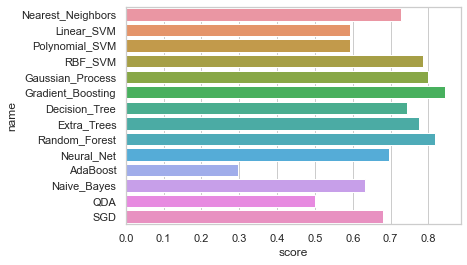

In [255]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)

In [256]:
training_scores = []
for name, clf in zip(names, classifiers):
    training_score = clf.score(X_train, Y_train)
    training_scores.append(training_score)

df = pd.DataFrame()
df['name'] = names
df['training scores'] = training_scores
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,training scores
0,Nearest_Neighbors,0.729846
1,Linear_SVM,0.565389
2,Polynomial_SVM,0.565389
3,RBF_SVM,0.827302
4,Gaussian_Process,0.864923
5,Gradient_Boosting,1.000000
6,Decision_Tree,0.732354
7,Extra_Trees,1.000000
8,Random_Forest,1.000000
9,Neural_Net,0.683268


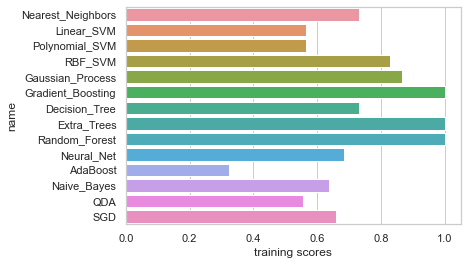

In [257]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="training scores", data=df)

In [258]:
import pickle

In [266]:
# save best model
pickle.dump(classifiers[5], open('boost_model.pkl','wb'))
pickle.dump(classifiers[8], open('rf_model_19_window_extra_stats.pkl','wb'))

In [220]:
type(classifiers[5])

sklearn.ensemble._gb.GradientBoostingClassifier

In [226]:
Y_val

array([2., 3., 2., 2., 2., 2., 2., 1., 2., 2., 2., 3., 2., 4., 2., 4., 3.,
       3., 3., 2., 2., 2., 2., 2., 3., 4., 2., 2., 1., 2., 1., 3., 2., 2.,
       2., 3., 2., 1., 3., 2., 1., 3., 2., 2., 2., 2., 3., 4., 2., 2., 2.,
       2., 3., 2., 4., 3., 2., 2., 3., 2., 2., 1., 2., 2., 2., 4., 2., 3.,
       2., 2., 3., 4., 2., 2., 3., 2., 3., 4., 2., 3., 3., 2., 2., 2., 3.,
       3., 2., 2., 2., 2., 2., 2., 4., 2., 4., 2., 2., 2., 2., 2., 3., 2.,
       2., 4., 2., 1., 2., 2., 1., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2.,
       1., 3., 2., 2., 3., 4., 4., 1., 3., 3., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 1., 4., 3., 2., 1., 2., 2., 4., 2., 2., 3., 2., 3., 2., 2.,
       3., 2., 2., 2., 3., 2., 2., 2., 4., 1., 2., 2., 3., 2., 2., 2., 2.,
       2., 2., 3., 1., 2., 2., 3., 2., 3., 2., 2., 2., 4., 1., 2., 2., 2.,
       2., 2., 2., 2., 4., 2., 2., 2., 2., 4., 4., 1., 2., 3., 1., 4., 3.,
       2., 3., 3., 1., 2., 2., 2., 2., 3., 2., 2., 2., 3., 2., 2., 2., 2.,
       3., 2., 2., 4., 2.

In [228]:
(classifiers[5].predict(X_val)==Y_val).mean()

0.8378088077336198

In [263]:

c_matrix = confusion_matrix(Y_val, classifiers[5].predict(X_val))
num_each_class = np.sum(c_matrix,axis=1)
num_predicted_correct = np.diagonal(c_matrix)
sgd_accuracy_classes = num_predicted_correct / num_each_class * 100

In [264]:
sgd_accuracy_classes

array([87.5       , 91.48550725, 71.3592233 , 71.79487179])